# Text Classification

In this problem, you will be again analyzing the Twitter data we extracted from 2016 using [this](https://dev.twitter.com/overview/api) api. This time, we extracted the tweets posted by the following six Twitter accounts: `realDonaldTrump, mike_pence, GOP, HillaryClinton, timkaine, TheDemocrats`.

For every tweet, we collected two pieces of information:
- `screen_name`: the Twitter handle of the user tweeting and
- `text`: the content of the tweet.

We divided the tweets into two parts - the train and test sets.  The training set contains both the `screen_name` and `text` of each tweet; the test set only contains the `text`.

The overarching goal of the problem is to infer the political inclination (whether **R**epublican or **D**emocratic) of the author from the tweet text. The ground truth (i.e., true class labels) are determined from the `screen_name` of the tweet as follows:
- **R**: `realDonaldTrump, mike_pence, GOP`
- **D**: `HillaryClinton, timkaine, TheDemocrats`

We can treat this as a binary classification problem. We'll follow this common structure to tackling this problem:

1. **preprocessing**: clean up the raw tweet text using regular expressions, and produce class labels
2. **features**: construct bag-of-words feature vectors
3. **classification**: learn a binary classification model using [`scikit-learn`](http://scikit-learn.org/stable/modules/classes.html). 


In [ ]:
import collections
import string
import numpy as np
import sklearn
import sklearn.feature_extraction
import sklearn.svm
import sklearn.metrics
import gzip
import re
import matplotlib.pyplot as plt
import pandas as pd

## A. Text Processing

### Q1 Preprocessing
Your first task is to fill in the following function which processes and tokenizes raw text. You will need to preprocess the tokens by applying the operators _in the following order_.

1. Convert the text to lower case.
2. Remove any URLs, which in this case will all be of the form `http://t.co/<alphanumeric characters>`.
3. Remove all trailing `'s` characters, followed by other apostrophes:
   - remove trailing `'s`: `Children's` becomes `children`
   - omit other apostrophes: `don't` becomes `dont`
4. Remove all non-alphanumeric (i.e., A-Z, a-z, 0-9) characters (replacing them with a single space)
5. Split the remaining text by whitespace into an array of individual words
6. Discard empty strings (i.e., if the string after processing above is equal to ""), return an empty array `[]` rather than `['']`

In [ ]:
def preprocess(text):
    """ Normalizes case and handles punctuation
    
    args:
        text: str -- raw text

    Outputs:
        list(str): tokenized text
    """
    text = text.lower()
    text = re.sub(r"http://t\.co/\w+", "", text)
    text = re.sub(r"'s\b", "", text)
    text = re.sub(r"'", "", text)
    text = re.sub(r"[^a-z0-9]+", " ", text)
    tokens = text.split()

    return tokens

### Q2 Loading Data

Using this preprocess function, load the data from the relevant csv files and return a list of the parsed tweets, plus a flag indicating whether or not the tweet is from a republican (i.e., one of the three usernames mentioned above); for the test data, where no screen name is given, provide `None` as the flag).  Note that this function should take less than a second if you've implemented the above preprocessing function efficiently.

In [ ]:
# @mugrade.local_tests
def read_data():
    """Reads the dataset from the tweets_train.csv.gz and tweets_test.csv.gz files
    
    return : Tuple (data_train, data_test)
        data_train : List[Tuple[is_republican, tokenized_tweet]]
            is_republican : bool -- True if tweet is from a republican
            tokenized_tweet : List[str] -- the tweet, tokenized by preprocess()
        data_test : List[Tuple[None, tokenized_tweet]
            None: the Python constant "None"
            tokenized_tweet : List[str] -- the tweet, tokenized by preprocess()
    """
    republican_accounts = {"realDonaldTrump", "mike_pence", "GOP"}

    train_df = pd.read_csv("tweets_train.csv")
    data_train = []
    for _, row in train_df.iterrows():
        screen_name = row["screen_name"]
        is_republican = screen_name in republican_accounts
        tokenized_tweet = preprocess(row["text"])
        data_train.append((is_republican, tokenized_tweet))

    test_df = pd.read_csv("tweets_test.csv")
    data_test = []
    for _, row in test_df.iterrows():
        tokenized_tweet = preprocess(row["text"])
        data_test.append((None, tokenized_tweet))

    return data_train, data_test

## B. Feature Construction

The next step is to derive feature vectors from the tokenized tweets. In this section, you will be constructing a bag-of-words [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) feature vector.


### Q3 Word distributions
The number of possible words is prohibitively large, and not all words are useful for our task. We will begin by filtering the vectors using a common heuristic: We calculate a frequency distribution of words in the corpus and remove words at the head (most frequent) and tail (least frequent) of the distribution. Most frequently used words (often called stopwords) provide very little information about the similarity of two pieces of text. Words with extremely low frequency tend to be typos.

We will now implement a function that counts the number of times that each token is used in the training corpus. You should return a [`collections.Counter`](https://docs.python.org/3/library/collections.html#collections.Counter) object with the number of times that each word appears in the dataset.

In [ ]:
def get_distribution(data):
    """ Calculates the word count distribution.

    args: 
        data -- the training or testing data

    return : collections.Counter -- the distribution of word counts
    """
    word_counts = collections.Counter()
    for _, tokenized_tweet in data:
        word_counts.update(tokenized_tweet)

    return word_counts

We can use this function, once implemented properly, to get a sense of the distribution of words in the training set.

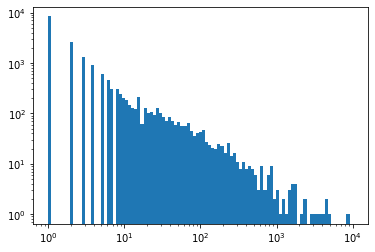

In [ ]:
data_train, data_test = read_data()
dist_train = get_distribution(data_train)
plt.yscale("log")
plt.xscale("log")
plt.hist(dist_train.values(), bins=np.logspace(0,4,100));

Notice that the plot looks roughly linear on this log-log plot (for those we are curious, this is a phenomenon known as [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)).  For us, however, it largely means that there are many words that appear many times (i.e., common words like "the"), which thus won't be very predictive for our task, because they are unlike to differentiate Republican vs. Democratic tweets.  There are also words that appear very infrequently, which also means that they aren't going to be very predictive, but for a different reason: these words likely won't occur very often in the test set, and thus will largely just cause the classifier to overfit to the training set.  However, instead of removing these words manually, in the next question, we will use the TFIDF weighting and vectorizer to both remove overly-common words and exclude too-infrequent words.

### Q4 Vectorizing

Now we have each tweet as a list of words, excluding words with high and low frequencies. We want to convert these into a sparse feature matrix, where each row corresponds to a tweet and each column to a possible word. We can use `scikit-learn`'s [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to do this quite easily.

Instructions:
 - By default, the `TfidfVectorizer` does its own tokenization, but we've already done it above, so you need to pass `preprocessor = lambda x : x, tokenization = lambda x : x, token_pattern=None` as arguments to the class constructor.
 - The vectorizer can filter words that are too uncommon or too common: to do this, set the `min_df=5` argument (words must be contained in more than 5 tweets), and `max_df=0.4` argument (filter out words contained in more than 40% of tweets)
 - You should use only the training data to `fit` or `fit_transform` the vectorizer.

In [ ]:
def create_features(train_data, test_data):
    """creates the feature matrices and label vector for the training and test sets.

    args:
        train_data, test_data : output of read_data() function

    returns: Tuple[train_features, train_labels, test_features]
        train_features : scipy.sparse.csr.csr_matrix -- TFIDF feature matrix for the training set
        train_labels : np.array[num_train] -- a numpy vector, where 1 stands for Republican and 0 stands for Democrat 
        test_features : scipy.sparse.csr.csr_matrix -- TFIDF feature matrix for the test set
    """
    train_texts = [" ".join(tokens) for _, tokens in train_data]
    train_labels = np.array([1 if is_republican else 0 for is_republican, _ in train_data])

    test_texts = [" ".join(tokens) for _, tokens in test_data]

    vectorizer = TfidfVectorizer(
        preprocessor=lambda x: x,
        tokenizer=lambda x: x,
        token_pattern=None,
        min_df=5,
        max_df=0.4
    )
    train_features = vectorizer.fit_transform(train_texts)
    test_features = vectorizer.transform(test_texts)

    return train_features, train_labels, test_features

Observe that the created matrices are very sparse, which is to be expected especially for tweets (given that each tweet can only contain relatively few words).

## C. Classification

We are now ready to put it all together and train the classification model.

You will be using the Support Vector Machine [`sklearn.svm.LinearSVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn). This class implements a linear SVM as we described in class, though of course, the details vary a little bit with this particular implementation.

### Q5 Training a classifier

Let's begin by training a classifier. You should specifically train a `LinearSVC` with a given set of features and labels, plus the regularization parameter specified by `C`.  You can additionally include as arguments to the `LinearSVC` class the `loss = "hinge"` argument (so that this is a typical SVM), and the `random_state=0` argument (to avoid any randomness in the training).  **Additionally, you should use the `max_iter=10000` argument to make sure that you run for enough iterations to avoid any failure to converge given the regularization parameters we use**.

In [ ]:
def train_classifier(features, labels, C):
    """learns a classifier from the input features and labels using a specified kernel function

    args:
        features: scipy.sparse.csr.csr_matrix -- sparse matrix of features
        labels : numpy.ndarray(bool): binary vector of class labels
        C : float -- C regularization parameters

    returns: sklearn.svm.LinearSVC -- classifier trained on data
    """
    classifier = LinearSVC(
        C=C,
        loss="hinge",
        random_state=0,
        max_iter=10000
    )
    classifier.fit(features, labels)

    return classifier

### Q6 Cross validation

After building the function to train this classifier, let's now use a validation set to pick the optimal value of `C`, out of the choices of `(0.01, 0.1, 1.0, 10.0)`.  The basic approach here will be to split the training set into the first 10000 samples for the training set, and the remainder for the validation set, allowing you to choose the best parameter to use on the training set.  To evaluate the quality of the classifier, you will use the [F1 score](https://en.wikipedia.org/wiki/F-score), a common metric for text classification, which you can compute using the `sklearn.metrics.f1_score` function.

Specifically, you should implement the function below, which will compute the training and validation F1 score for different classifiers trained with different values of C.

In [ ]:
def evaluate_classifier(features, labels, C = (0.01, 0.1, 1.0, 10., 100.), train_length=10000):
    """ Train multiple classifier based on the first train_length features of features/labels,
        one for each regularization parameter supplied in C, and return train/validation f1
        scores for each of the classifiers
    
    args:
        features: scipy.sparse.csr.csr_matrix -- sparse matrix of features
        labels : numpy.ndarray(bool): binary vector of class labels
        C : Tuple[float] -- tuple of C regularization parameters
        train_length: int -- use _first_ train_length features for training (and the rest of validation)
    
    return : List[Tuple[float, float]] -- list of F1 scores for training/validation for each C parameter
    """
    train_features = features[:train_length]
    train_labels = labels[:train_length]
    validation_features = features[train_length:]
    validation_labels = labels[train_length:]

    results = []
    for c in C:
        classifier = LinearSVC(C=c, loss="hinge", random_state=0, max_iter=10000)
        classifier.fit(train_features, train_labels)
        train_predictions = classifier.predict(train_features)
        validation_predictions = classifier.predict(validation_features)
        train_f1 = f1_score(train_labels, train_predictions)
        validation_f1 = f1_score(validation_labels, validation_predictions)
        results.append((train_f1, validation_f1))

    return results

### Q7 Classifying new Tweets

Finally, let's put this all together.  Using the _best_ `C` value you found in the previous part (i.e., build the classifiers and test which `C` value out of `(0.01, 0.1, 1.0, 10., 100.)` gives the highest F1 score on the _validation_ set (you can hardcode this value into the function below), train a classifier on the _entire_ training set, and make predictions for the test set.  You won't be able to evaluate how accurate these predictions are, of course, but you can use this classifier to classify tweets as being from Republican or Democratic sources (or perhaps more precisely, from being from one of the three aforementioned Republicans or three Democrats during the 2016 election).

In [ ]:
def predict_test(train_features, train_labels, test_features):
    """train the classifier on the training set and return predictions on the test set
    
    args:
        train_features: scipy.sparse.csr.csr_matrix -- sparse matrix of training features
        train_labels : numpy.ndarray(bool): binary vector of training class labels
        test_features: scipy.sparse.csr.csr_matrix -- sparse matrix of test set features

    return : numpy.ndarray(bool): array of predictions on the test set
    """
    classifier = LinearSVC(C=1.0, loss="hinge", random_state=0, max_iter=10000)
    classifier.fit(train_features, train_labels)

    # Predict on the test set
    test_predictions = classifier.predict(test_features)

    return test_predictions